# Distributed Recommendation System

Attached two text files of the Spotify dataset.
The file “artists.txt” includes the artist_id and artist_name for each artist exist in the system.
The file “plays.txt” includes user_id, artist_id, play_count with represent the total number of
plays for each user to each artist.
Use PySpark and answer the following questions:
1. (3 points) - How many artists exist in the dataset?
2. (3 points) - How many users exist in the dataset?
3. (4 points) - What is the minimum and maximum number of plays per artist?
4. (5 points) - Build a recommendation system using ALS algorithm and print the model
tuning (i.e., the searching of hyperparameters for the model).
5. (5 points) - How many iterations ALS required for convergence?
6. (5 points) - Perform a prediction (of any data you want) using the system you have built
in 4.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq

In [ ]:
!pip install pyspark==3.1.2

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import sys

from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

## Read the file artist

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split

# Create SparkSession
spark_artist = SparkSession.builder.appName("Artist Analysis").getOrCreate()

# Read the text file
text_file_path = "/content/artists.txt"
artist_file = spark_artist.read.text(text_file_path)

df_artist = artist_file.withColumn("artist_id", split(artist_file["value"], "\t").getItem(0))
df_artist = df_artist.withColumn("artist_name", split(df_artist["value"], "\t").getItem(1))

df_artist = df_artist.drop("value")

df_artist.show(10, truncate=False)
df_artist.printSchema()

+---------+----------------------------------+
|artist_id|artist_name                       |
+---------+----------------------------------+
|1240105  |André Visior                      |
|1240113  |riow arai                         |
|1240132  |Outkast & Rage Against the Machine|
|6776115  |小松正夫                          |
|1030848  |Raver's Nature                    |
|6671601  |Erguner, Kudsi                    |
|1106617  |Bloque                            |
|1240185  |Lexy & K. Paul                    |
|6671631  |Rev. W.M. Mosley                  |
|6671632  |Labelle, Patti                    |
+---------+----------------------------------+
only showing top 10 rows

root
 |-- artist_id: string (nullable = true)
 |-- artist_name: string (nullable = true)



In [ ]:
artists_count = df_artist.select('artist_id').distinct().count()
print("Number of users:", artists_count)

Number of users: 30537


## Read the file plays

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split

spark = SparkSession.builder.appName("Plays Analysis").getOrCreate()

# Read the text file and split the columns
text_file_path = "/content/plays.txt"
plays_file = spark.read.text(text_file_path)
df_plays = plays_file.select(
    split(plays_file["value"], " ").getItem(0).alias("user_id"),
    split(plays_file["value"], " ").getItem(1).alias("artist_id"),
    split(plays_file["value"], " ").getItem(2).alias("play_count")
)

df_plays.show(10, truncate=False)
df_plays.printSchema()

+-------+---------+----------+
|user_id|artist_id|play_count|
+-------+---------+----------+
|1059637|1000010  |238       |
|1059637|1000049  |1         |
|1059637|1000056  |1         |
|1059637|1000062  |11        |
|1059637|1000094  |1         |
|1059637|1000112  |423       |
|1059637|1000113  |5         |
|1059637|1000114  |2         |
|1059637|1000123  |2         |
|1059637|1000130  |19129     |
+-------+---------+----------+
only showing top 10 rows

root
 |-- user_id: string (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- play_count: string (nullable = true)



In [ ]:
users_count = df_plays.select('user_id').distinct().count()
print("Number of users:", users_count)

Number of users: 50


In [ ]:
df_plays = df_plays.withColumn("play_count", col("play_count").cast("integer"))
df_plays


DataFrame[user_id: string, artist_id: string, play_count: int]

## The minimum and maximum number of plays per artist:

In [ ]:
df_plays.filter(df_plays.artist_id == 1005313).show()

+-------+---------+----------+
|user_id|artist_id|play_count|
+-------+---------+----------+
|1024631|  1005313|         6|
|1055449|  1005313|        45|
+-------+---------+----------+



In [ ]:
from pyspark.sql import functions as F

artist_play_counts = df_plays.groupBy("artist_id").agg(F.min("play_count").alias("min_play_count"),F.max("play_count").alias("max_play_count"))

artist_play_counts.show()

+---------+--------------+--------------+
|artist_id|min_play_count|max_play_count|
+---------+--------------+--------------+
|  1129143|             2|          1020|
|      296|             1|           706|
|  1000795|            10|           242|
|  1133196|            42|            42|
|  1310393|            21|            21|
|  6789033|            42|            42|
|  6853367|            21|            21|
|      829|             1|           387|
|  1016518|             3|           317|
|  6806884|           145|           145|
|  6887745|             1|             1|
|  1062166|           350|           350|
|     1159|             6|            88|
|  1000280|             1|           138|
|  1001866|             2|            57|
|  1010108|            36|            36|
|  1031033|             1|             1|
|  1031057|             1|             1|
|  1235692|             4|             4|
|  1284412|             6|             6|
+---------+--------------+--------

## Build a recommendation system using ALS algorithm

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession

In [ ]:
plays = spark.read.text("plays.txt")
plays_data = plays.rdd \
    .map(lambda row: row.value.split(" ")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()

plays_data.take(3)

[(1059637, 1000010, 238.0), (1059637, 1000049, 1.0), (1059637, 1000056, 1.0)]

### Split Data

In [ ]:
train, validation, test = plays_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[68] at RDD at PythonRDD.scala:53

### ALS Model

In [ ]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (user_id, artist_id, play_count) tuple
                iterations=num_iters,
                rank=rank, # numbers of latent factors
                lambda_=reg,           # regularization param
                seed=99) # random seed for initial matrix factorization model
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            rates_preds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = rates_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

### The model tuning:

In [ ]:
# hyper-param config
num_iterations = 3
ranks = [8, 10, 12, 14, 16]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 5413.054226159869
8 latent factors and regularization = 0.01: validation RMSE is 3809.6033273561034
8 latent factors and regularization = 0.05: validation RMSE is 3025.478803095986
8 latent factors and regularization = 0.1: validation RMSE is 2990.9200142057925
8 latent factors and regularization = 0.2: validation RMSE is 2970.647740147571
10 latent factors and regularization = 0.001: validation RMSE is 6793.136857781779
10 latent factors and regularization = 0.01: validation RMSE is 3376.015442473903
10 latent factors and regularization = 0.05: validation RMSE is 2833.57825401064
10 latent factors and regularization = 0.1: validation RMSE is 2926.178049380604
10 latent factors and regularization = 0.2: validation RMSE is 2964.5138309585373
12 latent factors and regularization = 0.001: validation RMSE is 3910.4396656181857
12 latent factors and regularization = 0.01: validation RMSE is 3286.997234573556
12 latent factors a

## Number of iterations ALS required for convergence

In [ ]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        rates_preds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = rates_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

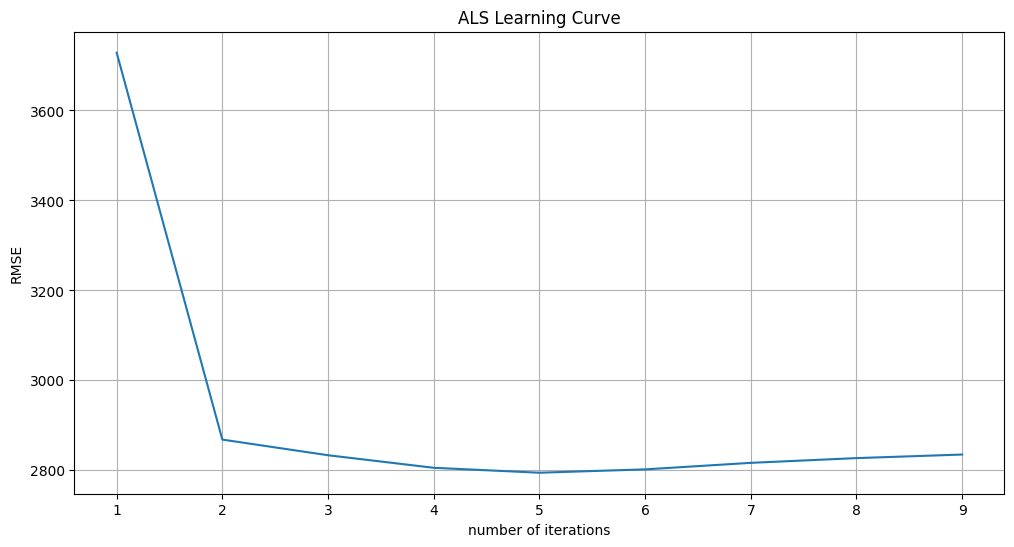

In [ ]:
# create an array of num_iters
iter_array = list(range(1, 10))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 10)

From this graph we see that 2 iterations are required for convergence

## Predicting favorite artists

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F

def artist_id_from_artist_name(artist_name):
    artist_id = df_artist.select("artist_id").where(col("artist_name") == artist_name[0]).first()
    if artist_id:
        return artist_id
    else:
        return None

def artist_name_from_artist_id(artist_id):
    artist_name = df_artist.select("artist_name").where(col("artist_id") == artist_id).first()
    if artist_name:
        return artist_name[0]
    else:
        return None

def get_artistID(df_plays, fav_artist_list):
    artistID_list = []
    for artist in fav_artist_list:
        artistIDs = df_plays \
            .filter(df_artist.artist_name.like('%{}%'.format(artist))) \
            .select('artist_id') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        artistID_list.extend(artistIDs)
    return list(set(artistID_list))


def add_new_user_to_data(train_data, artistId_list, spark_context):
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, artistId, max_rating) for artistId in artistId_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, df_plays, artistId_list):
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_plays.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in artistId_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, df_movies,
                        fav_movie_list, n_recommendations, spark_context):
    # modify train data by adding new user's rows
    movieId_list = get_artistID(df_movies, fav_movie_list)
    train_data = add_new_user_to_data(ratings_data, movieId_list, spark_context)

    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)

    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_movies, movieId_list)

    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))

    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]

    return topn_ids



In [ ]:
# my favorite artist
my_favorite_artist = ['Aerosmith']
my_favorite_artistID = artist_id_from_artist_name(my_favorite_artist)
print(my_favorite_artistID)
# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 5, 'rank': 10, 'lambda_': 0.05},
    ratings_data=plays_data,
    df_movies=df_artist,
    fav_movie_list=my_favorite_artist,
    n_recommendations=10,
    spark_context=spark_artist.sparkContext)
print('Recommendations for {}:'.format(my_favorite_artist[0]))
for i, artist in enumerate(recommends):
    print('{0}: {1}'.format(i+1, artist_name_from_artist_id(artist)))

Row(artist_id='1000010')
Recommendations for Aerosmith:
1: System of a Down
2: Sage Francis
3: Jawbreaker
4: Alkaline Trio
5: Current 93
6: Pixies
7: Alanis Morissette
8: The Bouncing Souls
9: Frédéric Chopin
10: Rage Against the Machine
